# Задача 1


Требуется получить состояние:
$$
\ket{\psi} = \frac{1}{\sqrt{45}} \sum_{k = 1}^{45} \ket{2k - 1}
$$

Наша команда решила использовать вариационную квантовую схему (VQC) для приближение искомого состояния. Мы вдохновлялись данной статьёй  https://doi.org/10.1002/qute.201900070, в которой предложены разные вариационные схемы для приближения любого состояния. Наша команда выбрала схему 6 (circuit 6) с рисунка 2, так как она является самой выразительной. 

Мы использовали Fidelity как функцию ошибки. Fidelity является физически измеримой и наиболее логичной лосс функцией, так как она определяет меру близости между состояними. Пусть $U(\boldsymbol{\theta})$ - анзатц, а $\ket{\psi}$ - вектор состояния, который мы хотим получить, $\ket{0}$ - исходное вакуумное состояние. Тогда фиделити определяется как

$$
Fid = \bra{\psi} U(\boldsymbol{\theta}) \ket{0}
$$

Максимальное значение фиделити равно 1, то есть когда состояние $\ket{\psi}$ совпадает с $U(\boldsymbol{\theta})\ket{0}$.

Схема процесса оптимизации (VQC) представлена на рисунке.



![Схема процесса оптимизации.](схема.png)

Импорт нужных библиотек

In [8]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import pennylane as qml
torch.set_default_dtype(torch.float64)

Код для визуализации схем и состояний.

In [9]:
def get_res_state(params, circuit, n_layers, number_of_odds = 45):
    num_qubits = int(np.ceil(np.log2(2 * number_of_odds - 1)))
    vector = circuit(params, n_layers).detach().numpy()
    state_ampl = dict()
    for i in range(0, 1 << num_qubits):
        s = f"|{i}>"
        state_ampl[s] = np.round(np.abs(vector[i]), 3)
    return state_ampl

def plot_res_state(state_ampl):
    plt.figure(figsize=(55,10))
    plt.bar(range(len(state_ampl)), state_ampl.values(), width=1, edgecolor='black', facecolor='skyblue')
    plt.hlines(1/np.sqrt(45), 0, len(state_ampl), color='red', linestyles='--')
    plt.xticks(range(len(state_ampl)), state_ampl.keys(), rotation=90, fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel(r'Состояния', fontsize=30)
    plt.ylabel(r'Вероятности', fontsize=30)
    plt.title(r'Итоговое распределение вероятностей для состояния $|\psi\rangle = \frac{1}{\sqrt{45}}\ \sum_{n = 0}^{45} |2k-1\rangle$', fontsize=40)
    plt.tight_layout()
    plt.show()

def print_circuit(circuit, params, n_layers):
    fig, ax = qml.draw_mpl(circuit)(params, n_layers=n_layers)
    plt.show()

def plot_all_fidelities(fid_circ):
    plt.figure(figsize=(10, 5))
    plt.xlabel('Итерация')
    plt.ylabel('Фиделити')
    plt.title('Эволюция фиделити во время обучения')
    plt.grid(True)
    for circ in fid_circ.keys():
        plt.plot(fid_circ[circ], label=f'Схема {circ}')
    plt.legend()
    plt.show()

def plot_bar_num_of_pars(pars_circ):
    plt.figure(figsize=(10, 5))
    plt.xlabel('Номер схемы')
    plt.ylabel('Количество параметров')
    plt.title('Гистограмма числа параметров')
    plt.grid(True)
    for circ in pars_circ.keys():
        plt.bar(circ, len(pars_circ[circ]), label=f'Схема {circ}')
    plt.legend()
    plt.show()

Функция фиделити.

In [10]:
def fidelity_loss(predicted, target):
    inner = torch.vdot(target, predicted)
    fid = torch.abs(inner) ** 2
    loss = 1 - fid
    return loss, fid

Кодируем целые числа в исходном состоянии в битовые строки из 7 битов. В схеме 7 кубит, так как 45-ое нечетное число - это 89. А $2^6 = 64 < 89 < 128 = 2^7$.

In [11]:
def create_target_state():
    target = np.zeros(128, dtype=np.complex128)
    for k in range(1, 46):
        target[2 * k - 1] = 1.0
    target /= np.sqrt(45)
    return torch.tensor(target, dtype=torch.complex128)

Создаем анзац. Количество анзацов в схеме - 10.

In [12]:
n_qubits = 7
dev = qml.device("default.qubit", wires=n_qubits, shots=None)
@qml.qnode(dev, interface="torch", diff_method="backprop")
def circuit6(params, n_layers=10):
    param_idx = 0
    for _ in range(n_layers):
        for w in range(n_qubits):
            qml.RX(params[param_idx], wires=w); param_idx += 1
            qml.RZ(params[param_idx], wires=w); param_idx += 1
        for ctrl in range(n_qubits):
            for tgt in range(n_qubits):
                if ctrl != tgt:
                    qml.CRX(params[param_idx], wires=[ctrl, tgt]); param_idx += 1
    return qml.state()

Функция обучения. Оптмизатор Adam, шаг обучения 0.01, 310 итераций + планировщик уменьшающий в два раза шаг обучения, если loss не уменьшается в течении 50 итераций.

In [13]:
def train_pennylane_circuit(
    n_layers=10,
    n_epochs=300,
    lr=0.01,
):
    target = create_target_state()
    n_params = n_layers * n_qubits * (n_qubits + 1)
    params = nn.Parameter(
        torch.empty(n_params, dtype=torch.float64).uniform_(-torch.pi, torch.pi)
    )
    optimizer = torch.optim.Adam([params], lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=50, factor=0.5)

    fidelities = []

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        state = circuit6(params, n_layers=n_layers)
        loss, fid = fidelity_loss(state, target)
        loss.backward()
        optimizer.step()
        scheduler.step(fid.item())

        fidelities.append(fid.item())
        if epoch % 10 == 0:
            print(f"Epoch {epoch:4d} | Fidelity: {fid.item():.12f}")

    return fidelities, params


Тренируем нашу схему на 10 слоях, проводим 310 итераций. В результате мы подберем необходимые параметры.

Epoch    0 | Fidelity: 0.003191410293
Epoch   10 | Fidelity: 0.573927511638
Epoch   20 | Fidelity: 0.887193068858
Epoch   30 | Fidelity: 0.964700267343
Epoch   40 | Fidelity: 0.985946974168
Epoch   50 | Fidelity: 0.995853180400
Epoch   60 | Fidelity: 0.998320549381
Epoch   70 | Fidelity: 0.999444417489
Epoch   80 | Fidelity: 0.999768154903
Epoch   90 | Fidelity: 0.999931228513
Epoch  100 | Fidelity: 0.999968625883
Epoch  110 | Fidelity: 0.999990099895
Epoch  120 | Fidelity: 0.999997201662
Epoch  130 | Fidelity: 0.999998627102
Epoch  140 | Fidelity: 0.999999599383
Epoch  150 | Fidelity: 0.999999842464
Epoch  160 | Fidelity: 0.999999951698
Epoch  170 | Fidelity: 0.999999982689
Epoch  180 | Fidelity: 0.999999994770
Epoch  190 | Fidelity: 0.999999998101
Epoch  200 | Fidelity: 0.999999999249
Epoch  210 | Fidelity: 0.999999999764
Epoch  220 | Fidelity: 0.999999999900
Epoch  230 | Fidelity: 0.999999999960
Epoch  240 | Fidelity: 0.999999999986
Epoch  250 | Fidelity: 0.999999999994
Epoch  260 |

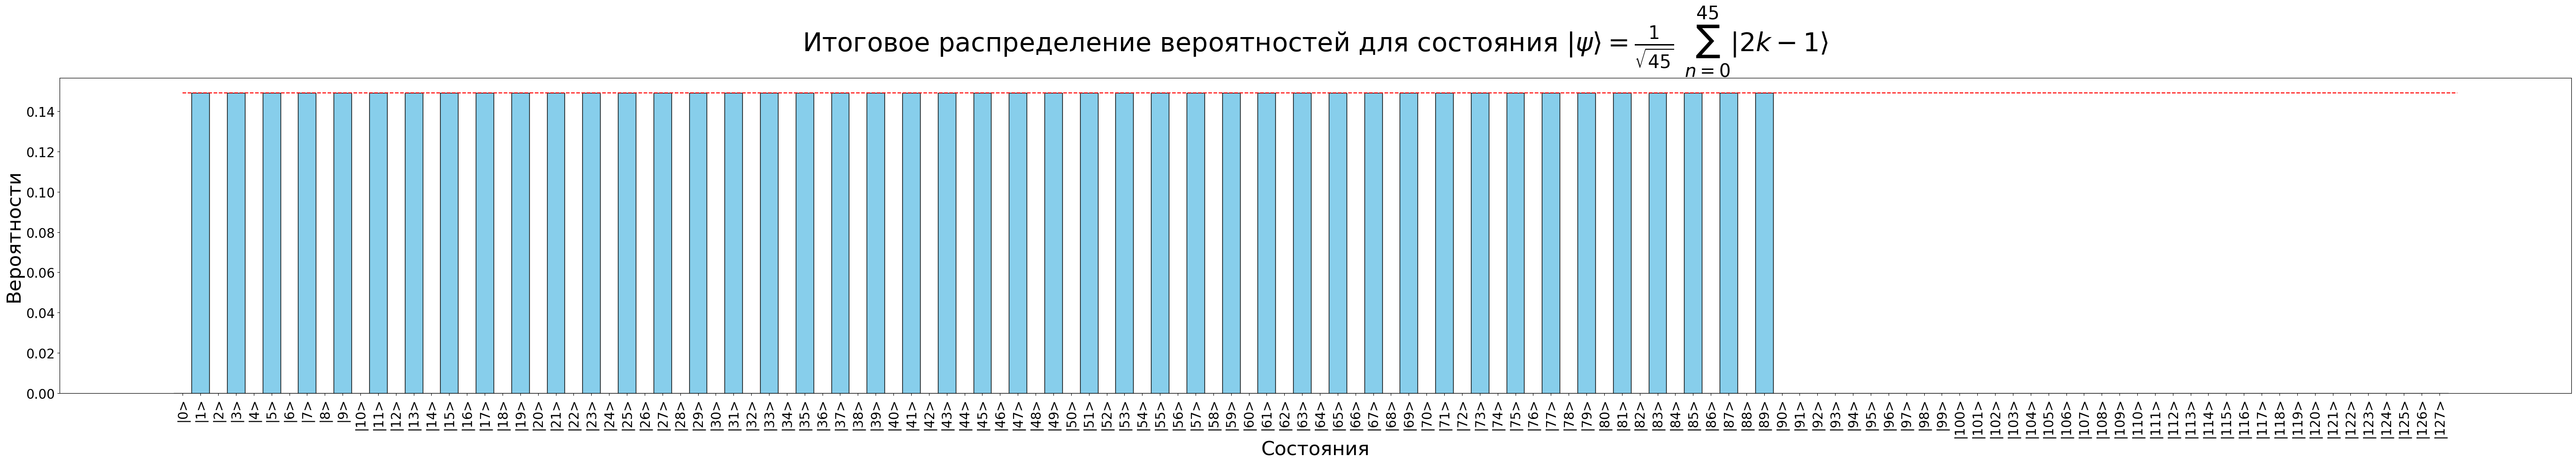

In [14]:
n_layers = 10
n_epochs = 310

fid_circ = {}
par_circ = {}
circ = '6'
fid_circ[circ], par_circ[circ] = train_pennylane_circuit(n_layers=n_layers, n_epochs=n_epochs)
state_ampl = get_res_state(par_circ[circ], circuit=circuit6, number_of_odds=45, n_layers=n_layers)
plot_res_state(state_ampl)

Красным пунктиром показан уровень $\frac{1}{\sqrt{45}}$ - вероятность, которую должно иметь каждое нечетное число.

График обучения + количество параметров в схеме представлены ниже.

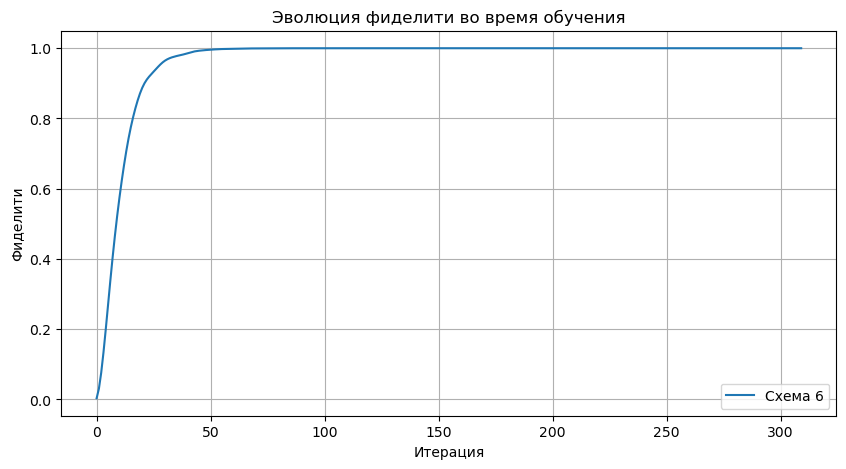

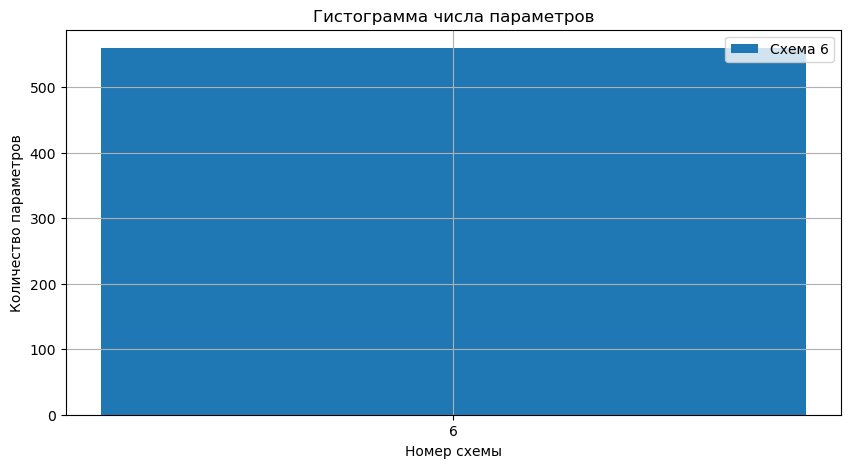

In [15]:
plot_all_fidelities(fid_circ)
plot_bar_num_of_pars(par_circ)

Рисунок схемы. Один слой. Таких слоев мы использовали 10, чтобы получить максимальную сходимость.


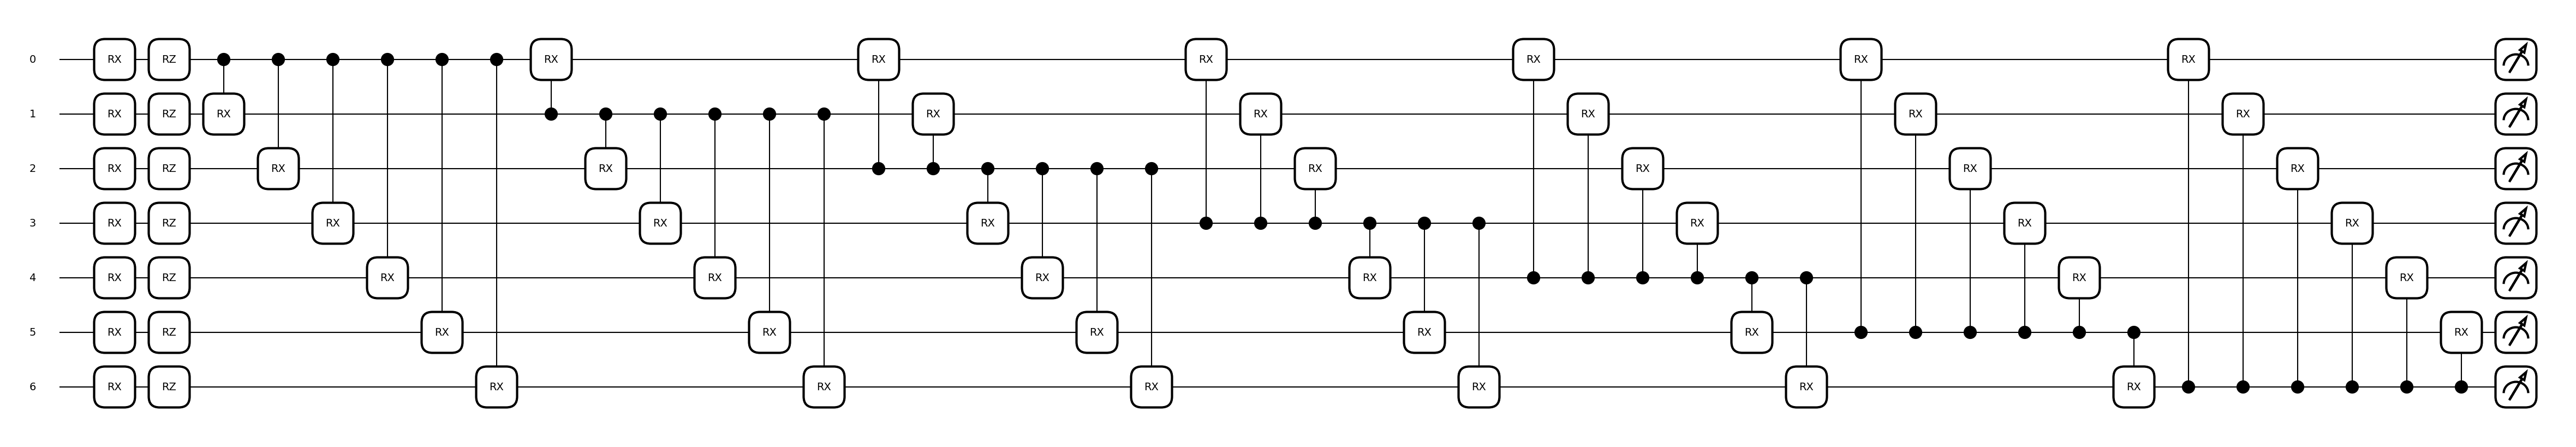

In [16]:
print_circuit(circuit6, par_circ[circ], 1)

Выводим финальное состояние, чтобы убедиться, что мы получаем вероятности $\frac{1}{\sqrt{45}} \approx 0.149$ для каждого нечетного состояния в суперпозиции.

In [17]:
print(get_res_state(par_circ['6'], circuit=circuit6, number_of_odds=45, n_layers=n_layers))

{'|0>': 0.0, '|1>': 0.149, '|2>': 0.0, '|3>': 0.149, '|4>': 0.0, '|5>': 0.149, '|6>': 0.0, '|7>': 0.149, '|8>': 0.0, '|9>': 0.149, '|10>': 0.0, '|11>': 0.149, '|12>': 0.0, '|13>': 0.149, '|14>': 0.0, '|15>': 0.149, '|16>': 0.0, '|17>': 0.149, '|18>': 0.0, '|19>': 0.149, '|20>': 0.0, '|21>': 0.149, '|22>': 0.0, '|23>': 0.149, '|24>': 0.0, '|25>': 0.149, '|26>': 0.0, '|27>': 0.149, '|28>': 0.0, '|29>': 0.149, '|30>': 0.0, '|31>': 0.149, '|32>': 0.0, '|33>': 0.149, '|34>': 0.0, '|35>': 0.149, '|36>': 0.0, '|37>': 0.149, '|38>': 0.0, '|39>': 0.149, '|40>': 0.0, '|41>': 0.149, '|42>': 0.0, '|43>': 0.149, '|44>': 0.0, '|45>': 0.149, '|46>': 0.0, '|47>': 0.149, '|48>': 0.0, '|49>': 0.149, '|50>': 0.0, '|51>': 0.149, '|52>': 0.0, '|53>': 0.149, '|54>': 0.0, '|55>': 0.149, '|56>': 0.0, '|57>': 0.149, '|58>': 0.0, '|59>': 0.149, '|60>': 0.0, '|61>': 0.149, '|62>': 0.0, '|63>': 0.149, '|64>': 0.0, '|65>': 0.149, '|66>': 0.0, '|67>': 0.149, '|68>': 0.0, '|69>': 0.149, '|70>': 0.0, '|71>': 0.149, '